In [120]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [121]:
samp = pd.read_csv('submission.csv')
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

train.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [122]:
train.drop('id', inplace = True, axis = 1)
test.drop('id', inplace = True, axis = 1)

train.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [123]:
#check missing values

print(train.isnull().sum())
test.isnull().sum()

CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [124]:
# Remove duplicated rows

print(train.duplicated().sum())
train = train.drop_duplicates()
train.shape

0


(165034, 13)

In [125]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
CustomerId,165034.0,1.569201e+07,71397.816791,15565701.00,15633141.00,15690169.0,1.575682e+07,15815690.00
CreditScore,165034.0,6.564544e+02,80.103340,350.00,597.00,659.0,7.100000e+02,850.00
Age,165034.0,3.812589e+01,8.867205,18.00,32.00,37.0,4.200000e+01,92.00
Tenure,165034.0,5.020353e+00,2.806159,0.00,3.00,5.0,7.000000e+00,10.00
Balance,165034.0,5.547809e+04,62817.663278,0.00,0.00,0.0,1.199395e+05,250898.09
NumOfProducts,165034.0,1.554455e+00,0.547154,1.00,1.00,2.0,2.000000e+00,4.00
HasCrCard,165034.0,7.539537e-01,0.430707,0.00,1.00,1.0,1.000000e+00,1.00
IsActiveMember,165034.0,4.977702e-01,0.499997,0.00,0.00,0.0,1.000000e+00,1.00
EstimatedSalary,165034.0,1.125748e+05,50292.865585,11.58,74637.57,117948.0,1.551525e+05,199992.48
Exited,165034.0,2.115988e-01,0.408443,0.00,0.00,0.0,0.000000e+00,1.00


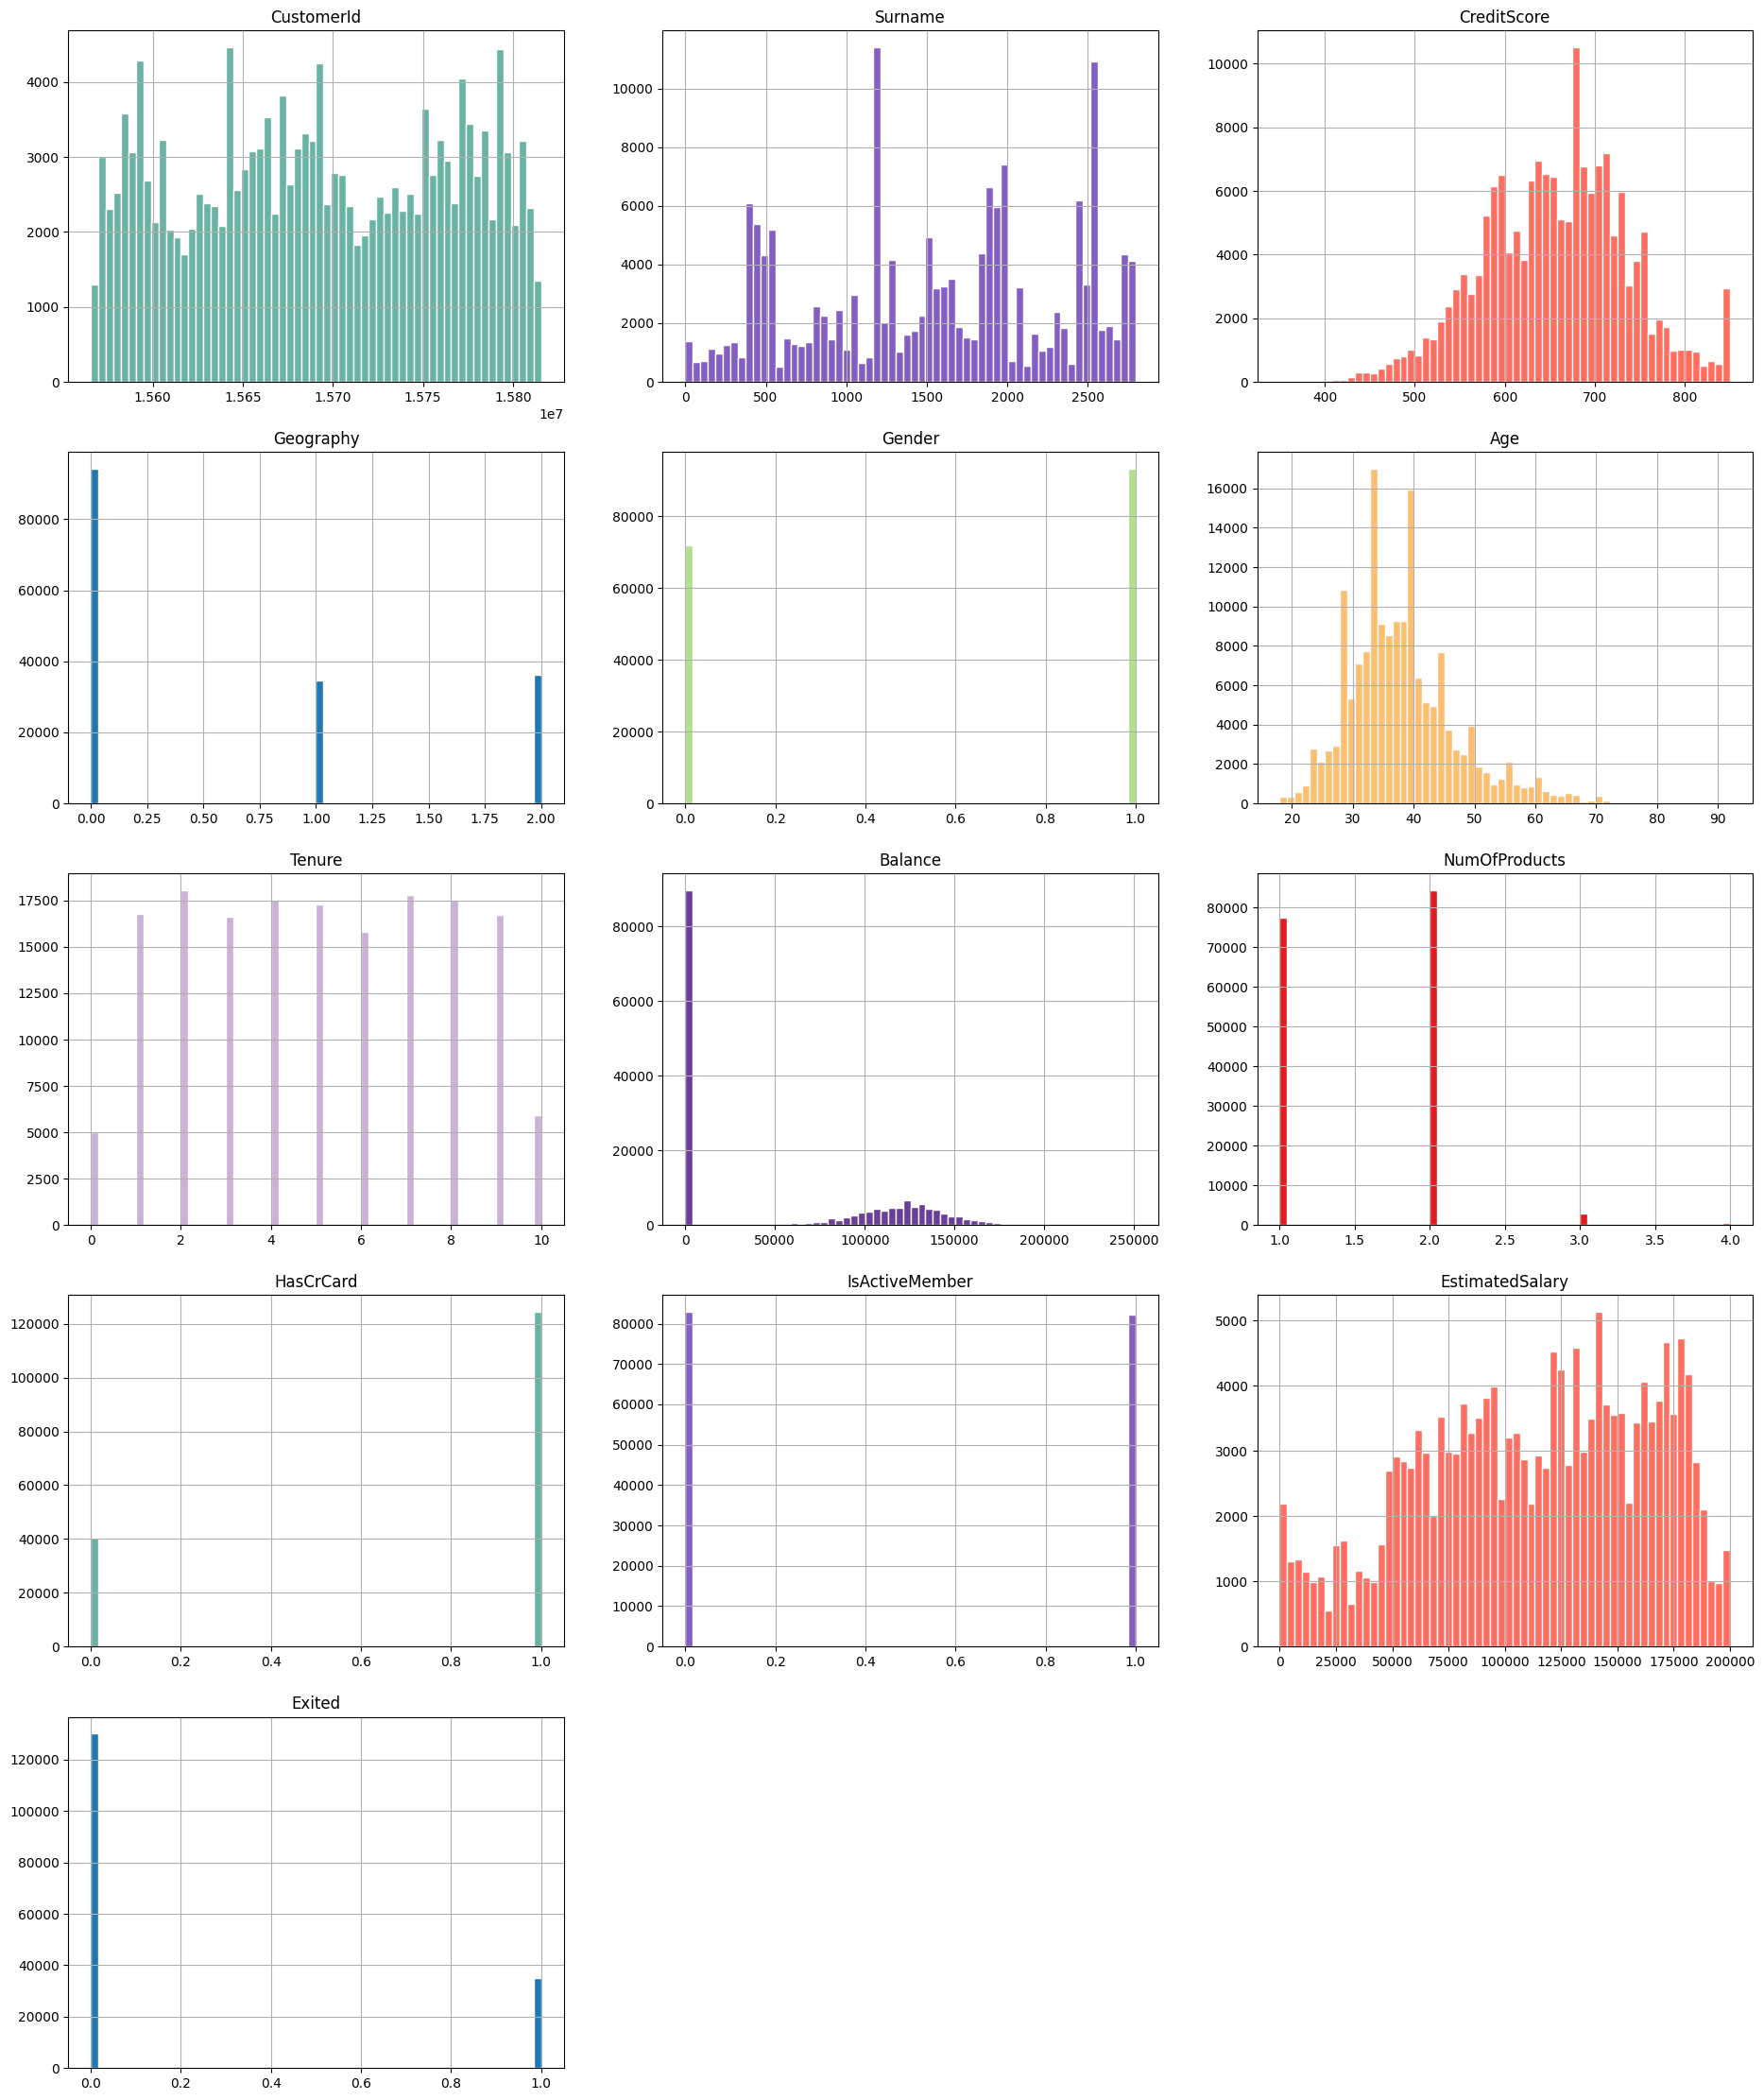

In [126]:
# Plotting every feature on the graph 

from sklearn.preprocessing import LabelEncoder
# Create a deep copy of train and name it data
data = train.copy()

label_encoder = LabelEncoder()
data['Geography'] = label_encoder.fit_transform(data['Geography'])
data['Gender'] = label_encoder.fit_transform(data['Gender'])
data['Surname'] = label_encoder.fit_transform(data['Surname'])

#data.hist(bins=60, figsize=(17,17), legend = True)

# Get the number of features in your dataset
num_features = len(data.columns)

# Calculate the number of rows and columns for subplots
num_rows = (num_features - 1) // 3 + 1
num_cols = min(num_features, 3)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols,  figsize=(12, 10))
axes = axes.flatten()

color_palette = ['#69b3a2', '#845ec2', '#ff6f61', '#1f78b4', '#b2df8a', '#fdbf6f', '#cab2d6', '#6a3d9a', '#e41a1c']

for i, column in enumerate(data.columns):
    color_index = i % len(color_palette) 
    data[column].hist(ax=axes[i], # Define on which ax we're working on
                    edgecolor='white', # Color of the border
                    color= color_palette[color_index],
                    figsize=(23,28),
                    bins = 60 # Color of the bins
                   )
    
    # Add title and axis label
    axes[i].set_title(f'{column}') 

#remove empty plots
for j in range(num_features, num_rows * num_cols):
    fig.delaxes(axes[j])

plt.show()

In [127]:
data.nunique()

CustomerId         23221
Surname             2797
CreditScore          457
Geography              3
Gender                 2
Age                   71
Tenure                11
Balance            30075
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary    55298
Exited                 2
dtype: int64

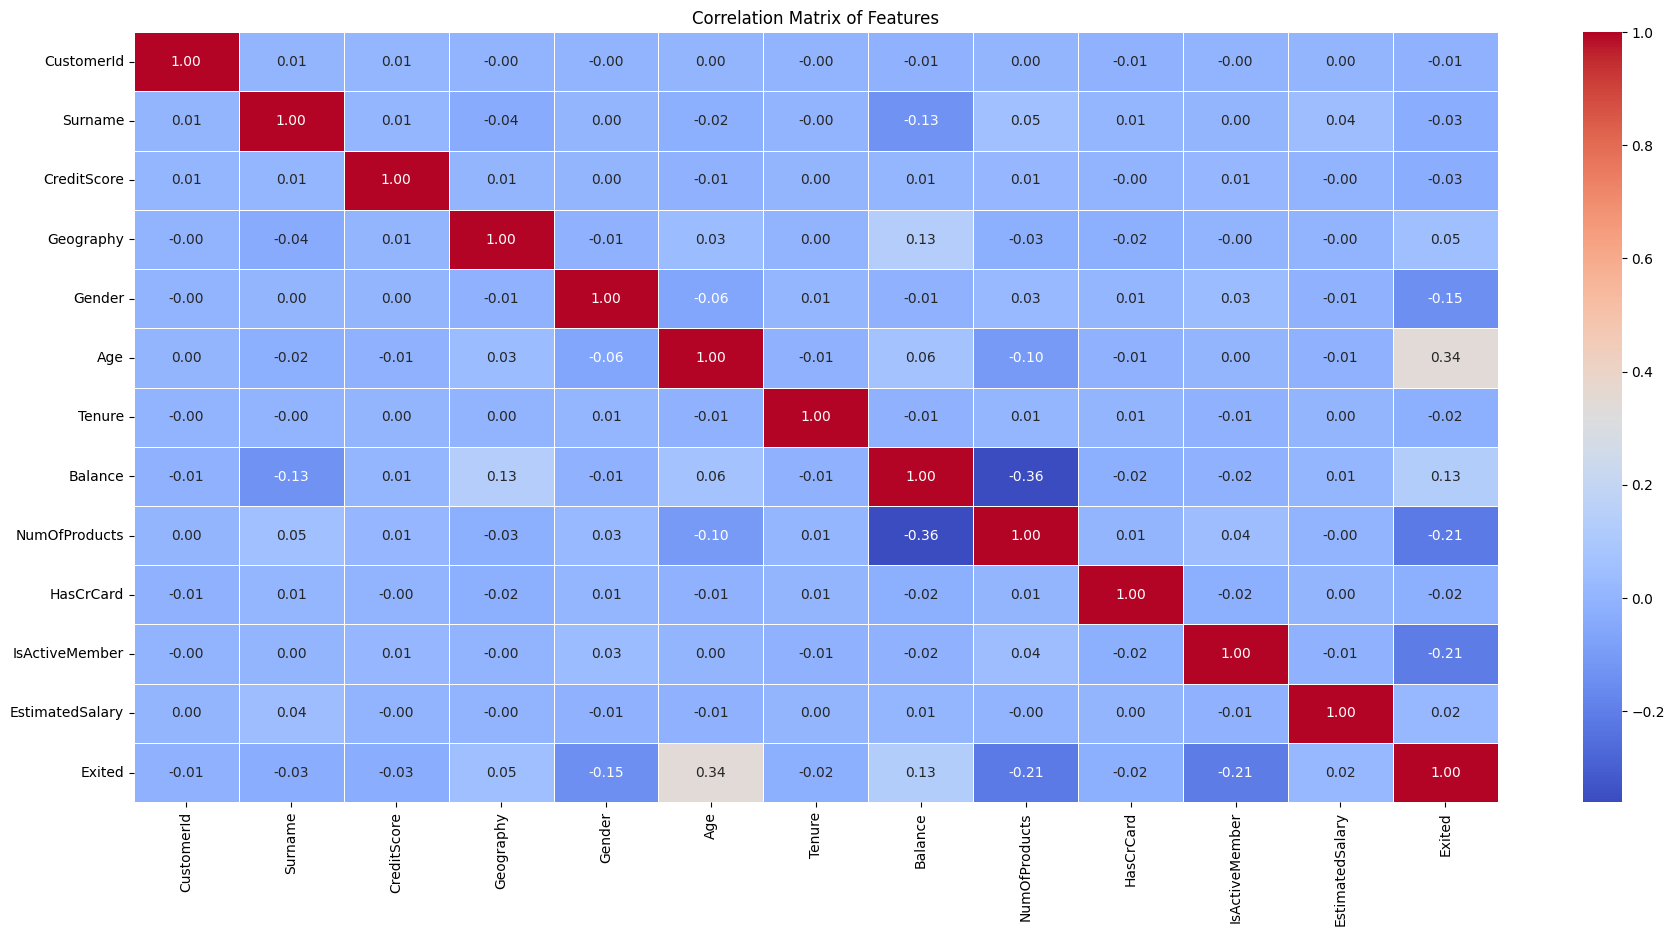

In [128]:
# Measuring correlation function
def corr(data):
    # Set up the matplotlib figure
    plt.figure(figsize=(22, 10))
    # Create a heatmap using Seaborn
    sns.heatmap(data, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    # Set the title of the plot
    plt.title('Correlation Matrix of Features')

corr(data.corr())


In [129]:
def geo_gender_tr(df) : 
    df['Geo_Gender'] = df['Geography'].astype('str') + '_' + df['Gender'].astype('str')
    return df

def cred_score_tr(df) : 
    df['Credit_Score_Range'] = pd.cut(df['CreditScore'], bins=[0, 300, 600, 700, 800, 900], labels=['0-300', '300-600', '600-700', '700-800', '900+'])
    return df

def age_tr(df) : 
    df['Age_Category'] = pd.cut(df['Age'], bins=[18, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'],include_lowest = True)
    return df

def is_young(df):
    df['IS_Young'] = pd.cut(df['Age'], bins = [18, 35, 100], labels = [0, 1 ], include_lowest = True)
    return df

def gen_active_tr(df) : 
    df['IsActive_Gender'] = df['IsActiveMember'].astype('str') + '_' + df['Gender'].astype('str')
    return df

def acc_sal_tr(df):
    df['Balance_Salary_Ratio'] = df['Balance'] / df['EstimatedSalary']
    return df

def age_sal_tr(df):
    df['Balance_Age_Ratio'] = df['Balance'] / df['Age']
    return df

def age_acc_tr(df):
    df['Salary_Age_ratio'] = df['EstimatedSalary'] / df['Age']
    return df

def tp_gender_tr(df) : 
    df['Tp_Gender'] = df['NumOfProducts'].astype('str') + df['Gender'].astype('str')
    return df

def meme(data):
    data['Mem__no__Products'] = data['NumOfProducts'] * data['IsActiveMember']
    return data

def credit_tenure(data):
    data['Credit_per_tenure'] = data['Tenure'] / data['CreditScore']
    return data

def salary_tenure(data):
    data['Credit_per_tenure'] = data['Tenure'] / data['EstimatedSalary']
    return data

In [130]:
data = geo_gender_tr(data)
data = cred_score_tr(data)
data = age_tr(data)
data = is_young(data)
data = gen_active_tr(data)
data = acc_sal_tr(data)
data = age_sal_tr(data)
data = age_acc_tr(data)
data = tp_gender_tr(data)
data = meme(data)
data = credit_tenure(data)
data = salary_tenure(data)

data['Geo_Gender'] = label_encoder.fit_transform(data['Geo_Gender'])
data['Credit_Score_Range'] = label_encoder.fit_transform(data['Credit_Score_Range'])
data['Age_Category'] = label_encoder.fit_transform(data['Age_Category'])
data['IsActive_Gender'] = label_encoder.fit_transform(data['IsActive_Gender'])
data['Tp_Gender'] = label_encoder.fit_transform(data['Tp_Gender'])

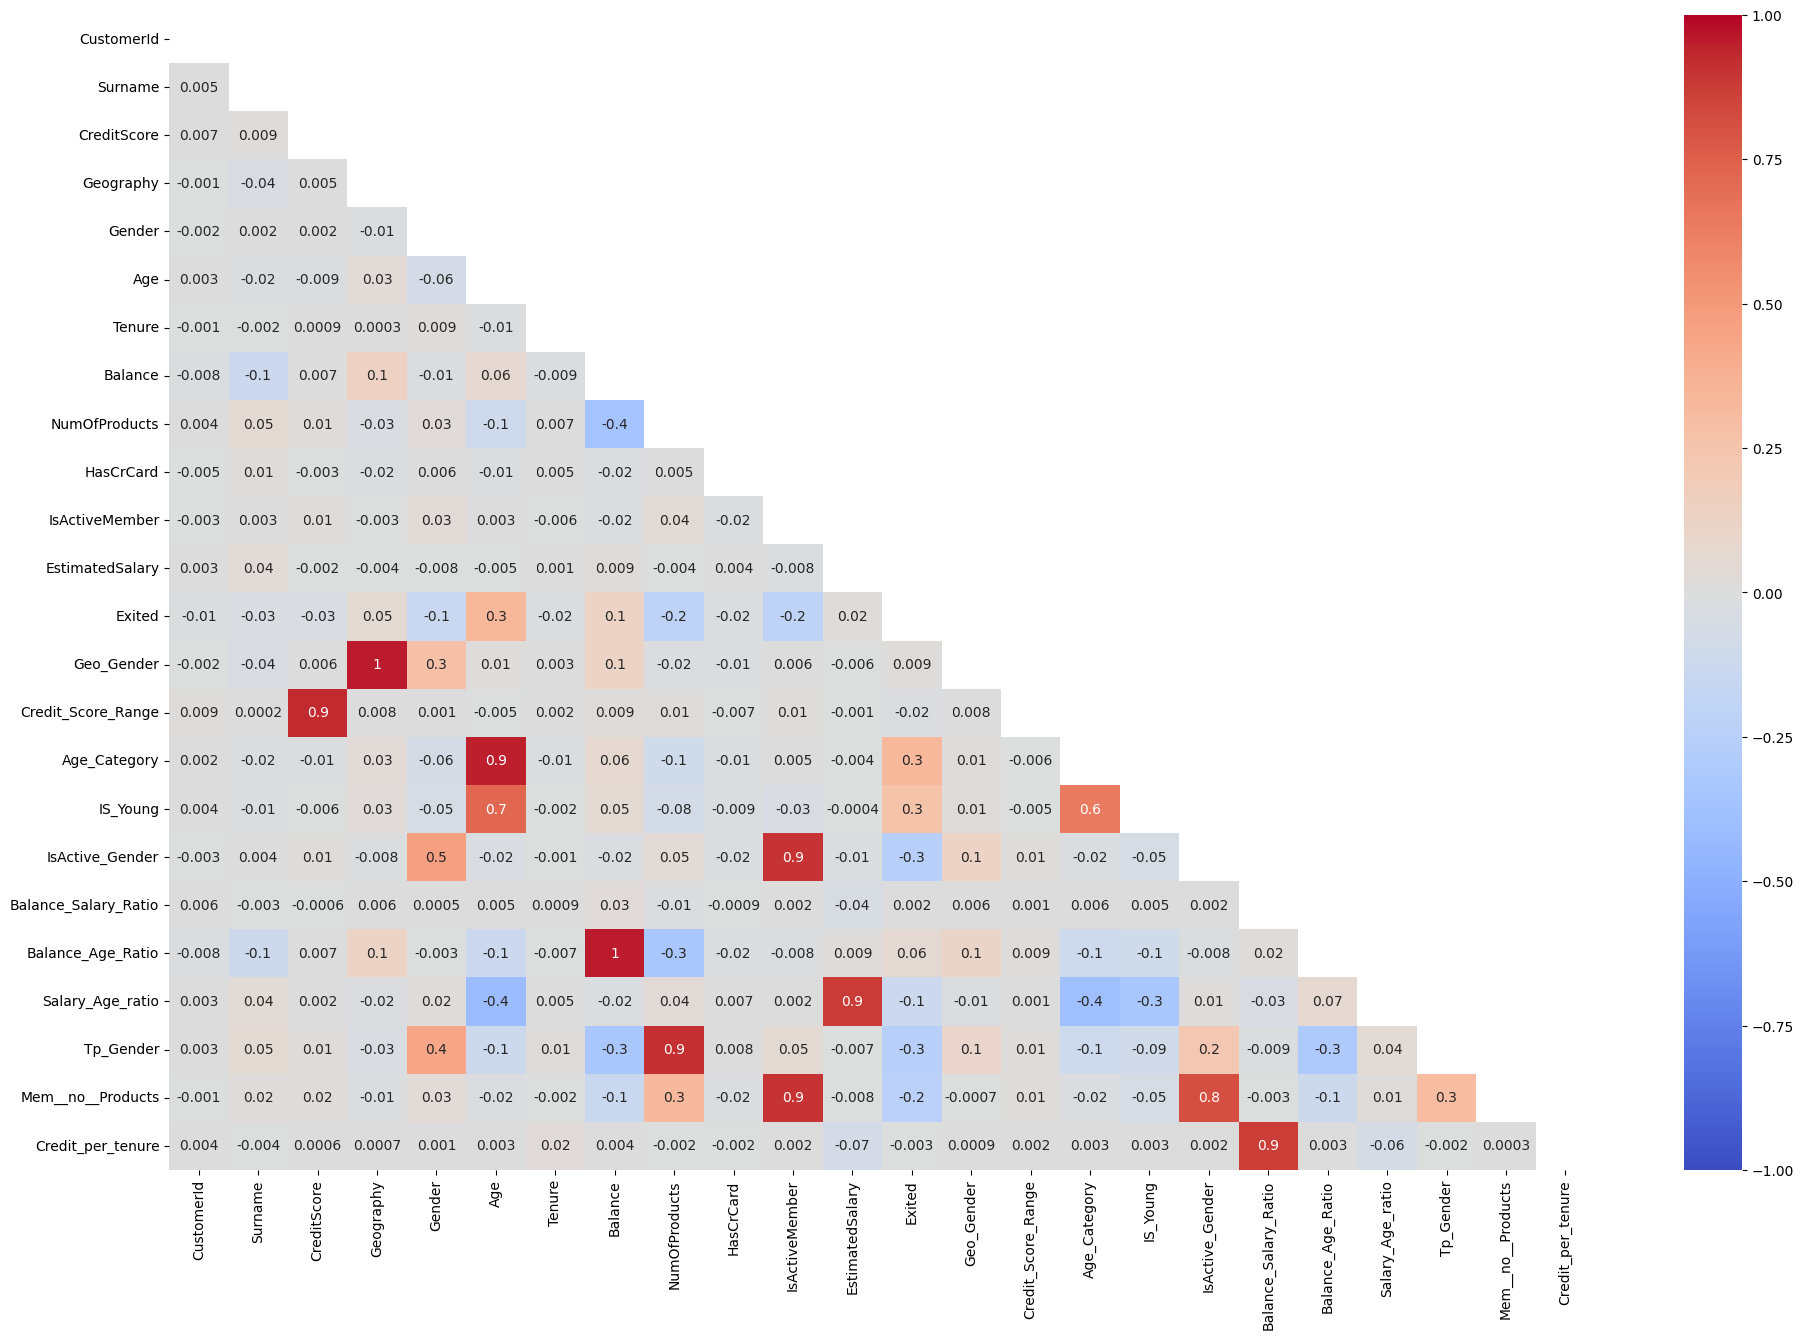

In [131]:
correlation_matrix = data.corr()
correlation_matrix_rounded = correlation_matrix.map(lambda x: round(x, 2))

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix_rounded, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(23, 15))

# Create a heatmap with the mask and a diverging colormap
sns.heatmap(correlation_matrix, mask=mask, cmap="coolwarm", vmax=1, vmin=-1, annot=True, fmt='.1g')

# Show the plot
plt.show()

# Ele criou varias features num dataset temporário, viu quais tinham maior correlancia com o Exited, e depois adicionou essas no train

In [132]:
label_encoder = LabelEncoder()

train['Surname'] = label_encoder.fit_transform(train['Surname'])
test['Surname'] = label_encoder.fit_transform(test['Surname'])

# New Feature 
train = age_tr(train)
train = is_young(train)
train = gen_active_tr(train)
train = age_sal_tr(train)
train = age_acc_tr(train)
train = tp_gender_tr(train)
train = meme(train)

test = age_tr(test)
test = is_young(test)
test = gen_active_tr(test)
test = age_sal_tr(test)
test = age_acc_tr(test)
test = tp_gender_tr(test)
test = meme(test)

In [133]:
X = train.drop('Exited', axis=1)
y = train['Exited']

# getting list of the numerical and categorical columns
num = X.select_dtypes(include=['int64', 'float64']).columns
col = X.select_dtypes(include=['object']).columns

categorical_features = X.select_dtypes(
    include=["object", "category"]
).columns.to_list()

In [134]:
# Preprocessing for numerical data: imputation and scaling
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())])

# Preprocessing for categorical data: imputation and one-hot encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num),
        ('cat', categorical_transformer, col)])

#preprocessor is the final pipeline, we will using it before the data feds into the ml algo.... using Pipeline

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rand_state = 1

In [136]:
catboost_model = CatBoostClassifier(
    random_seed=rand_state, cat_features=categorical_features, verbose=100, n_estimators=2000
)

In [137]:
catboost_model.fit(X_train, y_train)

Learning rate set to 0.043895
0:	learn: 0.6549939	total: 31ms	remaining: 1m 2s
100:	learn: 0.3208455	total: 3.48s	remaining: 1m 5s
200:	learn: 0.3170583	total: 7.04s	remaining: 1m 2s
300:	learn: 0.3144718	total: 10.8s	remaining: 1m
400:	learn: 0.3118653	total: 14.4s	remaining: 57.3s
500:	learn: 0.3097550	total: 17.9s	remaining: 53.6s
600:	learn: 0.3076464	total: 21.6s	remaining: 50.3s
700:	learn: 0.3057495	total: 25.2s	remaining: 46.7s
800:	learn: 0.3039527	total: 29.1s	remaining: 43.5s
900:	learn: 0.3021575	total: 33.3s	remaining: 40.6s
1000:	learn: 0.3004594	total: 37.1s	remaining: 37s
1100:	learn: 0.2988540	total: 41s	remaining: 33.5s
1200:	learn: 0.2972342	total: 44.7s	remaining: 29.8s
1300:	learn: 0.2956677	total: 48.7s	remaining: 26.2s
1400:	learn: 0.2941804	total: 52.5s	remaining: 22.4s
1500:	learn: 0.2926506	total: 56.4s	remaining: 18.7s
1600:	learn: 0.2911403	total: 1m	remaining: 15s
1700:	learn: 0.2897790	total: 1m 4s	remaining: 11.3s
1800:	learn: 0.2883790	total: 1m 7s	remai

In [138]:
y_pred_test = catboost_model.predict_proba(test)[:, 1]
y_pred_test

array([0.03051442, 0.8721263 , 0.01993409, ..., 0.04578868, 0.12317378,
       0.1647244 ])

In [139]:
samp["Exited"] = y_pred_test
samp.to_csv("submission.csv", index=False)
samp.head()

,id,Exited
0,165034,0.030514
1,165035,0.872126
2,165036,0.019934
3,165037,0.239231
4,165038,0.374088
